In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('TechStockDataForModelPrepped.csv')

In [4]:
df.head()

,HighCloseVolAvg_1,HighCloseVolAvg_10,HighCloseVolAvg_20,RSI,RSI_3_day_avg,RSI_10_day_avg,MACD,MACDHist,SP_change,Target
0,0.010693,0.018017,0.025879,51.144248,50.798745,45.626276,-2.243074,0.184151,0.023666,Yes
1,0.012521,0.015817,0.026274,53.432165,52.309578,46.428708,-1.884980,0.433796,0.008462,No
2,0.007963,0.014928,0.024169,54.732901,53.103105,47.573935,-1.509083,0.647755,-0.002483,No
3,0.020793,0.013226,0.021916,49.056194,52.407087,48.540104,-1.477920,0.543134,0.030791,Yes
4,0.001288,0.013255,0.020848,53.817714,52.535603,49.484500,-1.177072,0.675186,0.004034,No


In [12]:
df.shape

(49795, 10)

A reminder that the "Target" column is yes if SP_Change >= 0.0225 and No otherwise.

In [14]:
df['Target'].value_counts()

No     25134
Yes    24661
Name: Target, dtype: int64

### Train Test Split

To avoid any data leakage, I will do my train-test-split now.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train, test = train_test_split(df, test_size=0.1, random_state=42)

### EDA on train set

I will now perform EDA on train set.

In [17]:
train.head()

,HighCloseVolAvg_1,HighCloseVolAvg_10,HighCloseVolAvg_20,RSI,RSI_3_day_avg,RSI_10_day_avg,MACD,MACDHist,SP_change,Target
31044,0.057075,0.033616,0.026858,34.542485,37.977228,42.068735,-2.567551,-2.394810,0.009720,No
15080,0.030878,0.024051,0.024704,67.110055,63.510587,67.294932,5.295153,-0.004486,0.090179,Yes
45813,0.055524,0.042118,0.034658,51.845003,54.726098,56.551475,0.664850,-0.124630,-0.038550,No
30900,0.010136,0.023118,0.026445,56.765959,52.075108,51.894853,0.246142,0.444978,0.111960,Yes
18911,0.011009,0.012296,0.015745,54.608132,55.540147,51.153201,0.221360,0.981375,-0.019333,No


In [18]:
train['Target'].value_counts()

No     22612
Yes    22203
Name: Target, dtype: int64

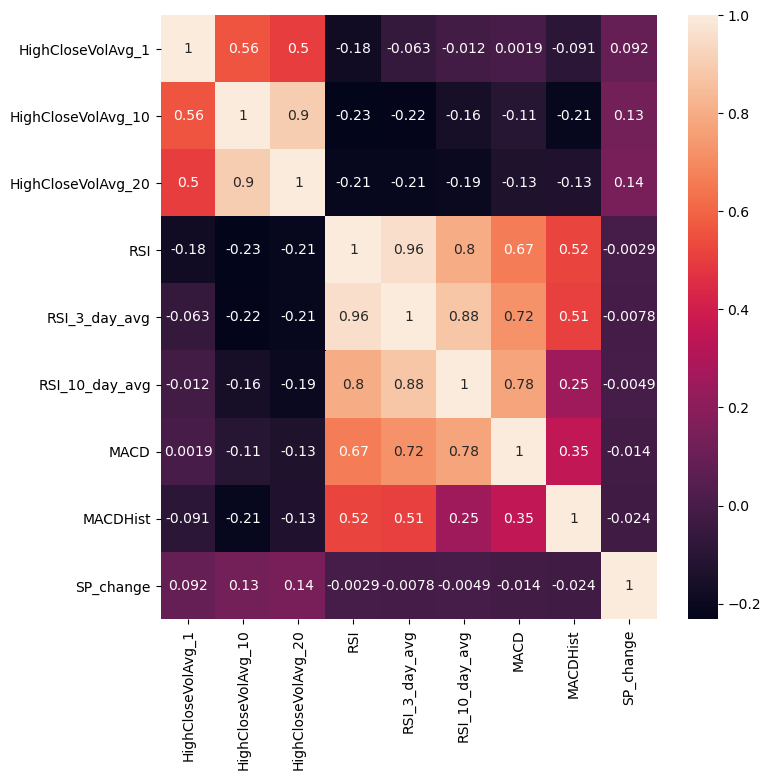

In [19]:
plt.figure(figsize=(8,8), dpi=100)

sns.heatmap(data=train.corr(), annot=True);

### Boxplots

I want to look at the boxplots for each of the numerical features to search for outliers.

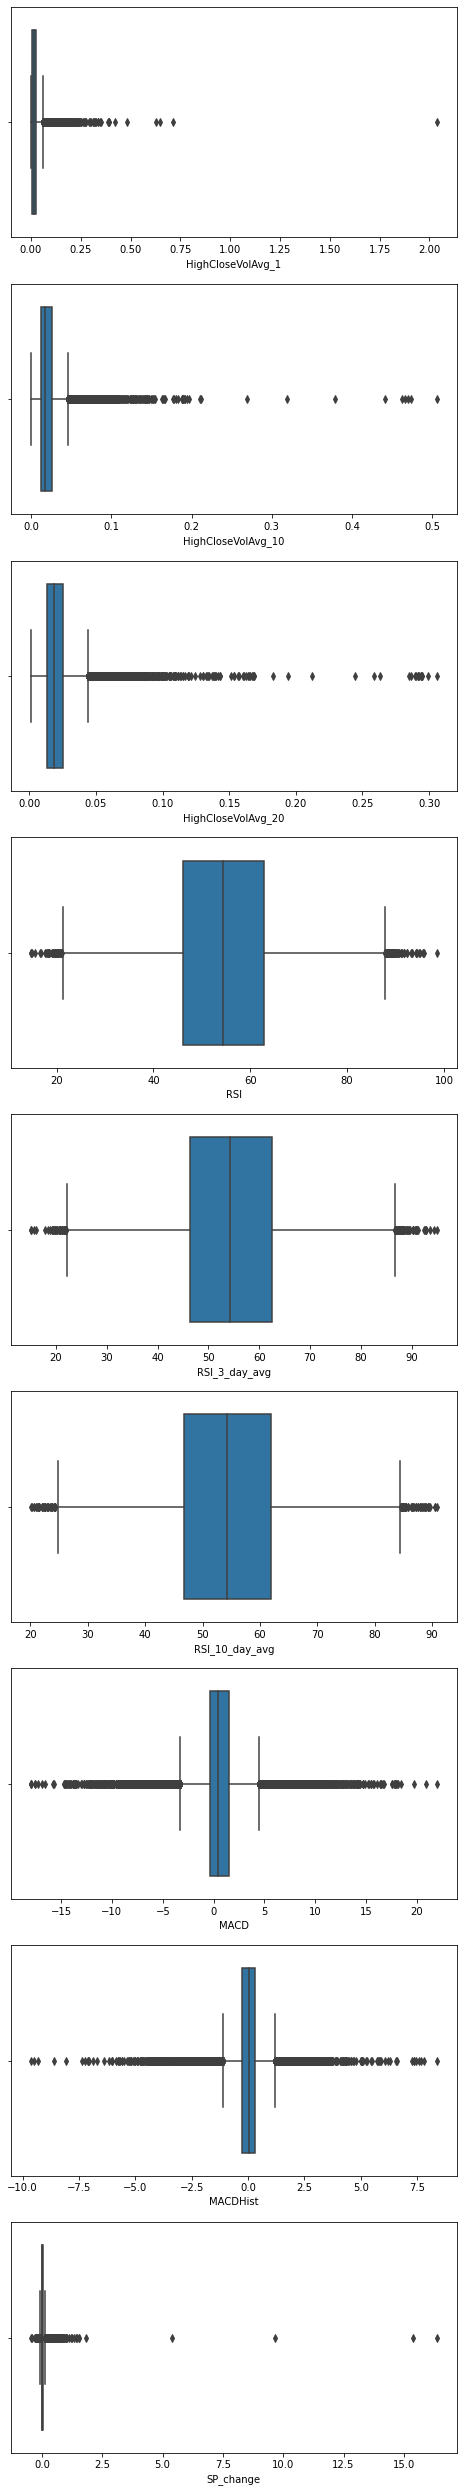

In [20]:
features = train.select_dtypes(include='number').columns

N = len(features)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 5*N))

counter = 0

for feat in features:
    sns.boxplot(data=train, x=feat, ax=ax[counter])
    counter += 1
    

There are many outliers. View histograms as well

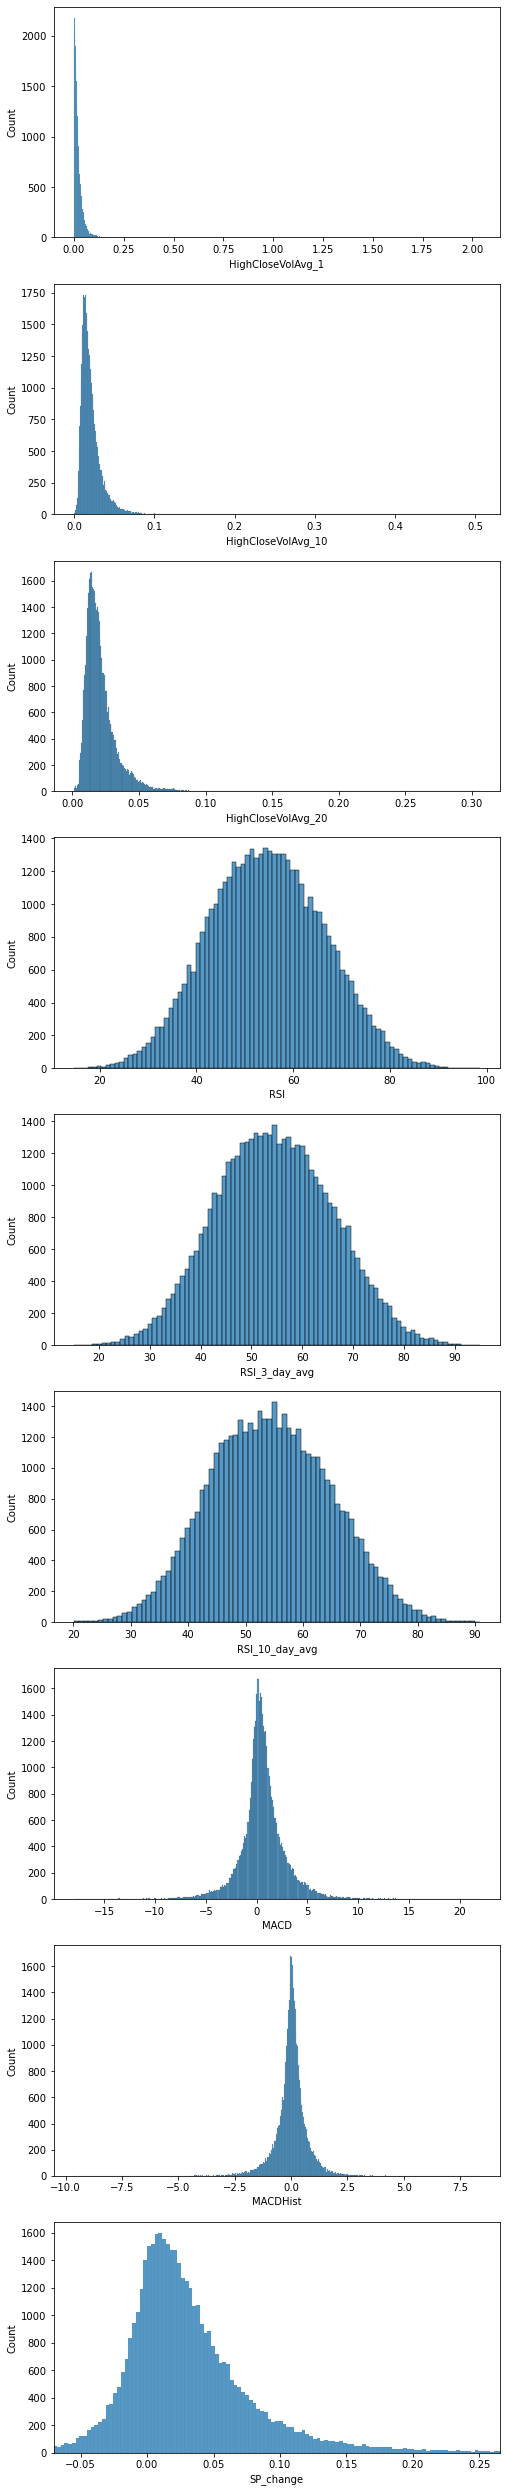

In [21]:
features = train.select_dtypes(include='number').columns

N = len(features)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 5*N))

counter = 0

for feat in features:
    sns.histplot(data=train, x=feat, ax=ax[counter])
    counter += 1
    
    lower = train[feat].quantile(q=0.01)
    upper = train[feat].quantile(q=0.99)
    
    plt.xlim(lower, upper);

The HighCloseVolAvg categories have one-sided distributions, so I will use the boxplot outliers for these two categories to remove.

For the remaining categories, since the distribution is close to normal, I will remove any data outside of 2 std from the mean

In [22]:
features = train.select_dtypes(include='number').columns

indices_no_outliers = train.index

boxplot_removals = ['HighCloseVolAvg_1', 'HighCloseVolAvg_10', 'HighCloseVolAvg_20']

for feat in boxplot_removals:
    q1 = train[feat].quantile(q=0.25)
    q3 = train[feat].quantile(q=0.75)

    iqr = q3-q1

    lower = q1-1.5*iqr
    upper = q1+1.5*iqr

    no_outliers = train[(train[feat]>lower) & (train[feat]<upper)]
    idx = no_outliers.index
    
    indices_no_outliers = np.intersect1d(indices_no_outliers, idx)
    
normal_removals = [x for x in features if x not in boxplot_removals]

for feat in normal_removals:
    mean = train[feat].mean()
    std = train[feat].std()
    
    lower = mean - 3*std
    upper = mean + 3*std
    
    no_outliers = train[(train[feat]>lower) & (train[feat]<upper)]
    
    idx = no_outliers.index
    
    indices_no_outliers = np.intersect1d(indices_no_outliers, idx)
    

no_outliers = train.loc[indices_no_outliers]

In [23]:
indices_no_outliers.shape

(32950,)

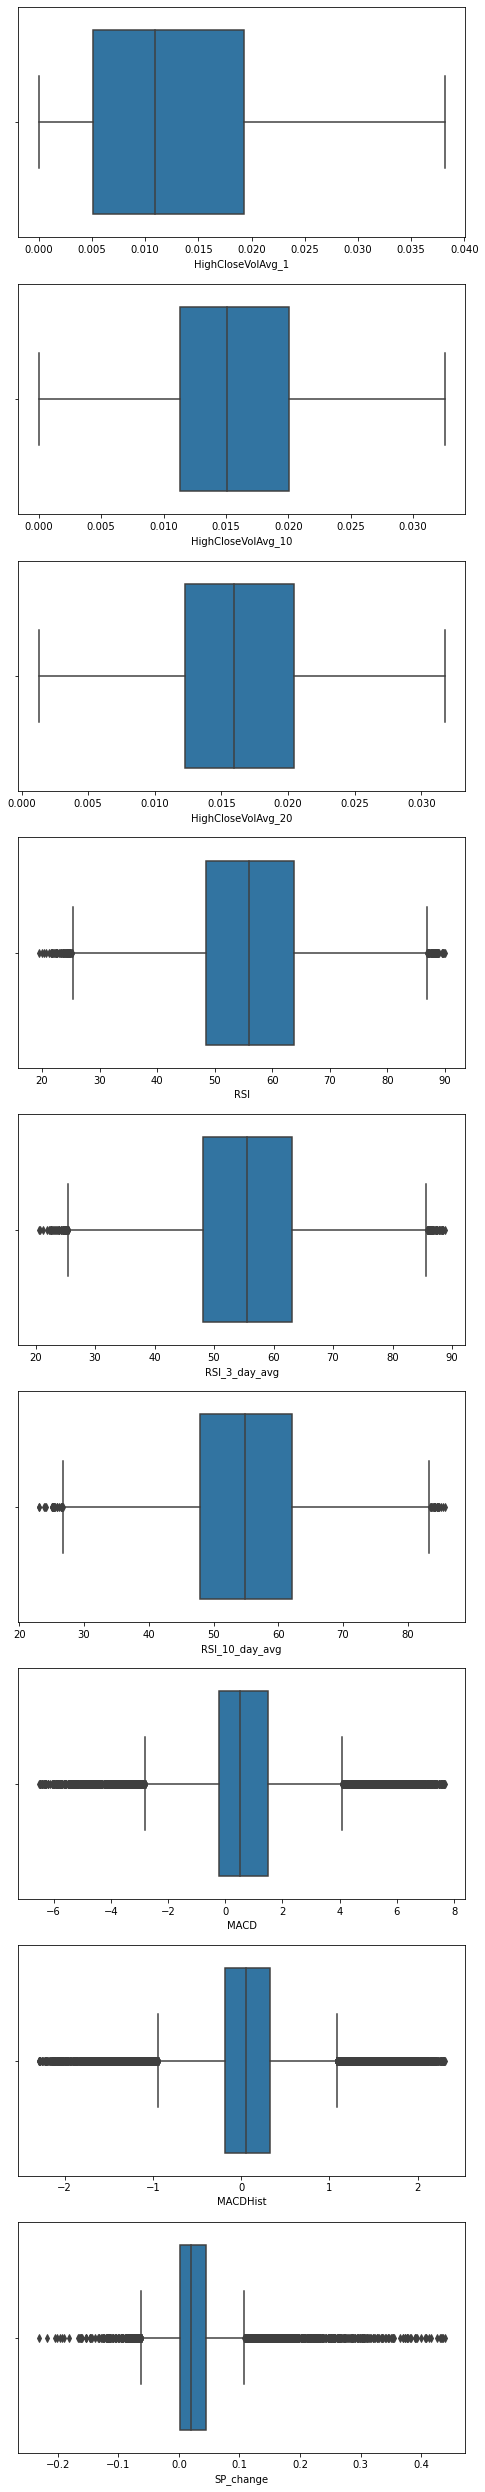

In [24]:
features = train.select_dtypes(include='number').columns

N = len(features)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 5*N))

counter = 0

for feat in features:
    sns.boxplot(data=no_outliers, x=feat, ax=ax[counter])
    counter += 1
    

In [25]:
train = no_outliers # rename for simplicity

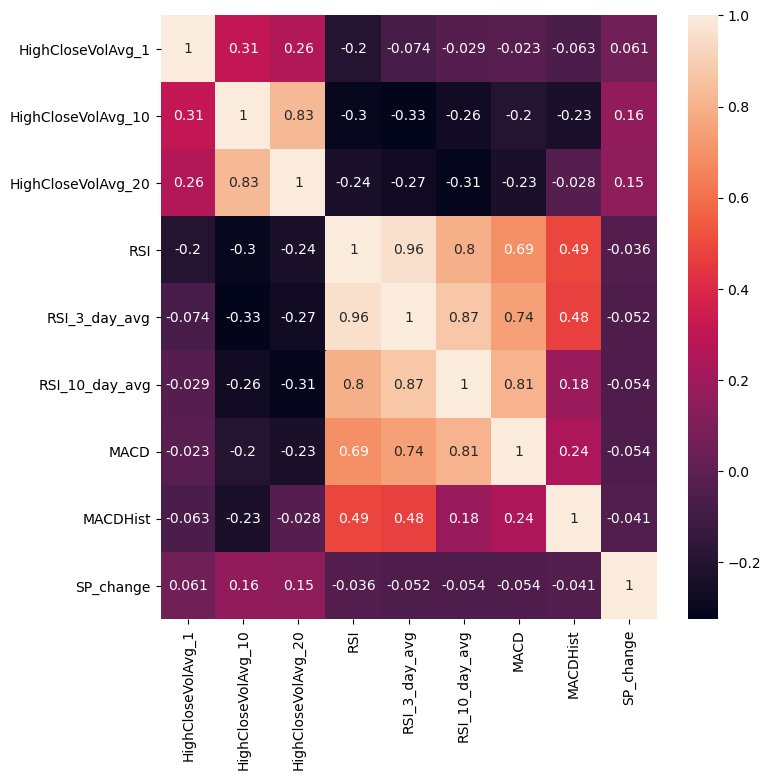

In [26]:
plt.figure(figsize=(8,8), dpi=100)
sns.heatmap(data=train.corr(), annot=True);

### RSI 

I will now look at the RSI related categories and how they relate to the target.

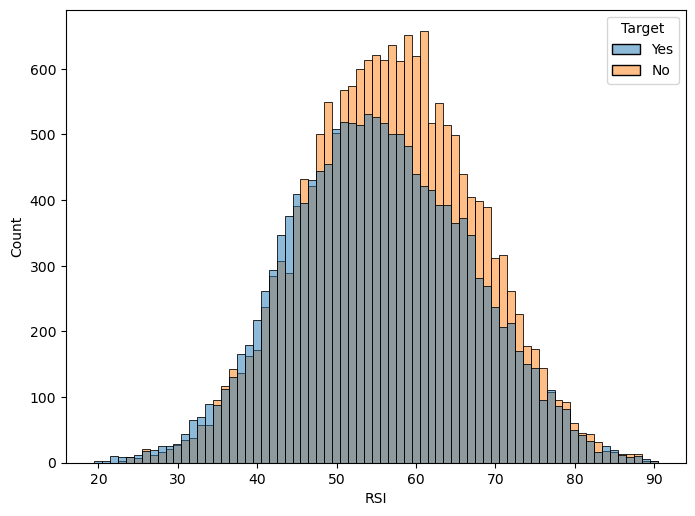

In [39]:
plt.figure(figsize=(8,6), dpi=100)

sns.histplot(data=train, x='RSI', hue='Target', binwidth=1);

In general, the SP should increase when RSI is lower, so our picture confirms this.

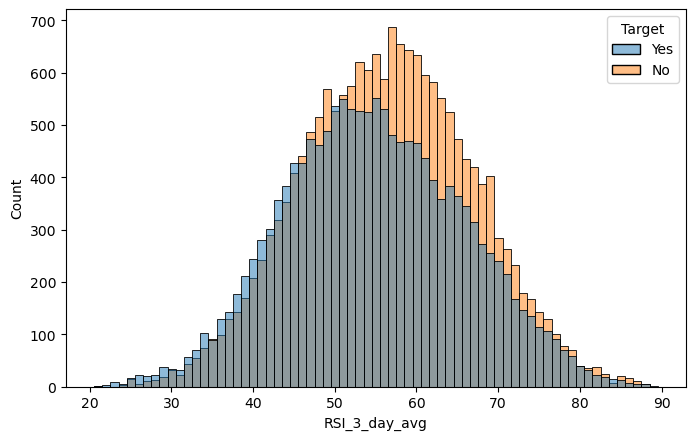

In [42]:
plt.figure(figsize=(8,5), dpi=100)

sns.histplot(data=train, x='RSI_3_day_avg', hue='Target', binwidth=1);

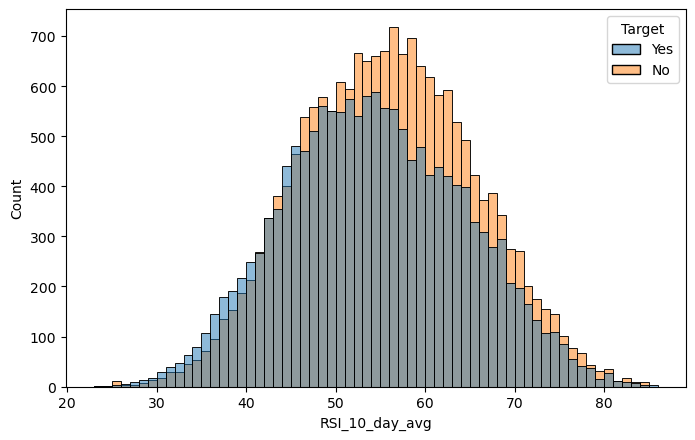

In [43]:
plt.figure(figsize=(8,5), dpi=100)

sns.histplot(data=train, x='RSI_10_day_avg', hue='Target', binwidth=1);

As the above shows, the lower each of the RSI categories, the more likely we are to see yes than no.

Note that the binwidth in each of the above is 1.

### Volatilities

The next set of features I would like to look at is the daily volatility averages.

<AxesSubplot:xlabel='HighCloseVolAvg_1', ylabel='Target'>

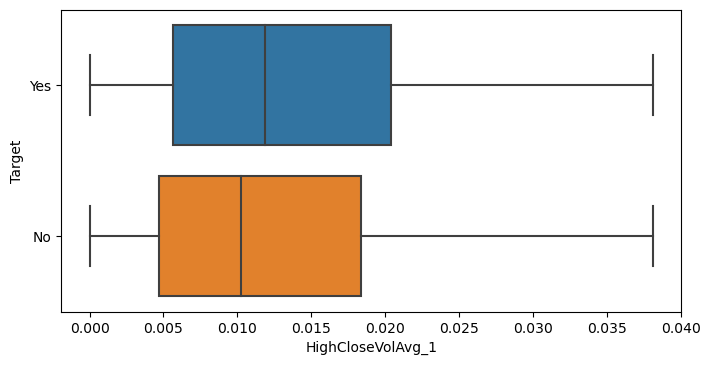

In [44]:
plt.figure(figsize=(8, 4), dpi=100)
sns.boxplot(data=train, x='HighCloseVolAvg_1', y='Target')

<AxesSubplot:xlabel='HighCloseVolAvg_1', ylabel='Count'>

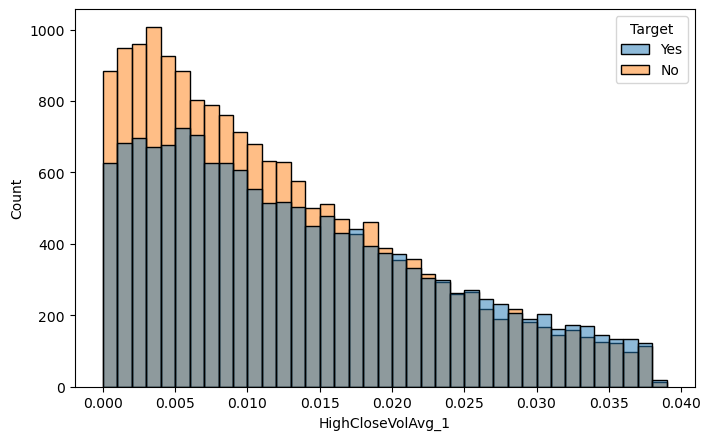

In [47]:
plt.figure(figsize=(8,5), dpi=100)

sns.histplot(data=train, x='HighCloseVolAvg_1', hue='Target', binwidth=0.001)

<AxesSubplot:xlabel='Target', ylabel='HighCloseVolAvg_1'>

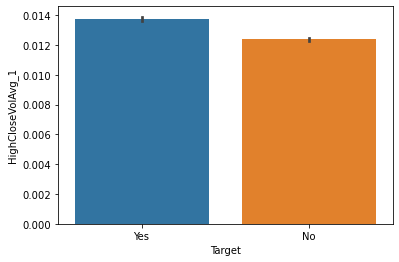

In [53]:
sns.barplot(data=train, x='Target', y='HighCloseVolAvg_1')

<AxesSubplot:xlabel='HighCloseVolAvg_10', ylabel='Target'>

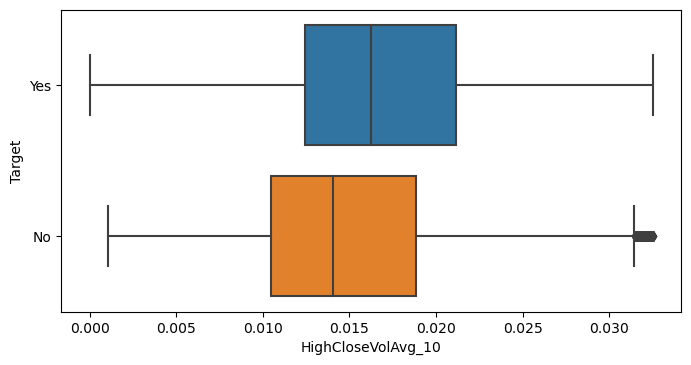

In [51]:
plt.figure(figsize=(8, 4), dpi=100)
sns.boxplot(data=train, x='HighCloseVolAvg_10', y='Target')

<AxesSubplot:xlabel='HighCloseVolAvg_10', ylabel='Count'>

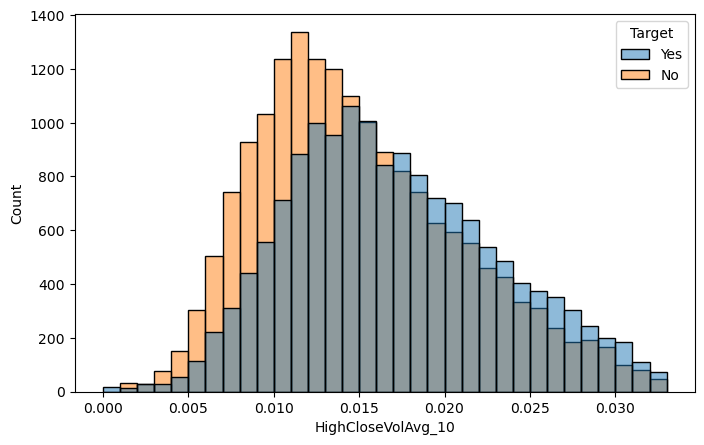

In [49]:
plt.figure(figsize=(8,5), dpi=100)

sns.histplot(data=train, x='HighCloseVolAvg_10', hue='Target', binwidth=0.001)

<AxesSubplot:xlabel='Target', ylabel='HighCloseVolAvg_10'>

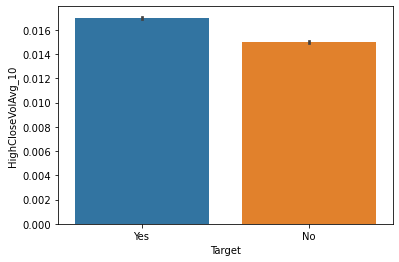

In [54]:
sns.barplot(data=train, x='Target', y='HighCloseVolAvg_10')

<AxesSubplot:xlabel='HighCloseVolAvg_20', ylabel='Target'>

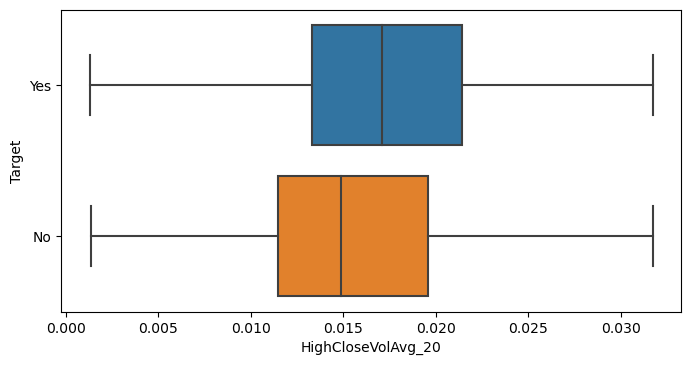

In [52]:
plt.figure(figsize=(8, 4), dpi=100)
sns.boxplot(data=train, x='HighCloseVolAvg_20', y='Target')

<AxesSubplot:xlabel='HighCloseVolAvg_20', ylabel='Count'>

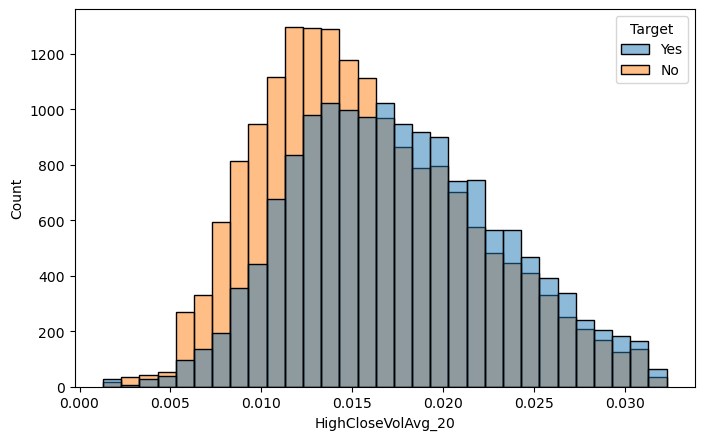

In [50]:
plt.figure(figsize=(8,5), dpi=100)

sns.histplot(data=train, x='HighCloseVolAvg_20', hue='Target', binwidth=0.001)

<AxesSubplot:xlabel='Target', ylabel='HighCloseVolAvg_20'>

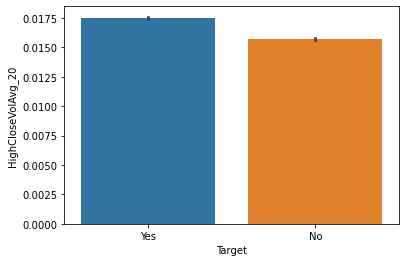

In [55]:
sns.barplot(data=train, x='Target', y='HighCloseVolAvg_20')

As we can see above, the higher the volatility average, the more likely it is to see a yes vs a no for the target

### MACD

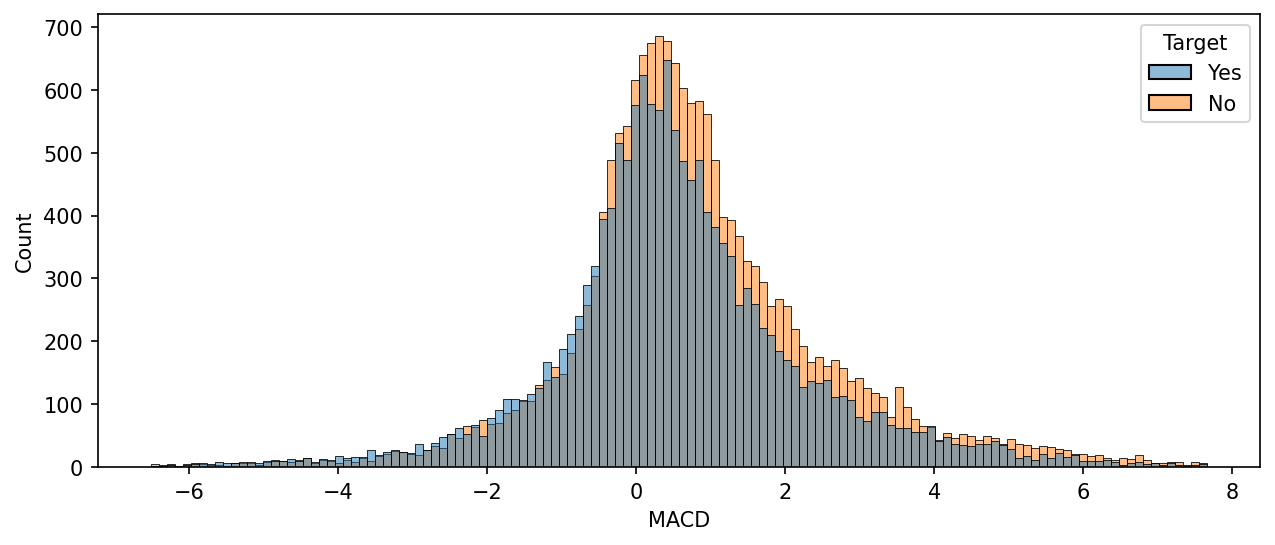

In [59]:
plt.figure(figsize=(10,4), dpi=150)
sns.histplot(data=train, x='MACD', hue='Target');

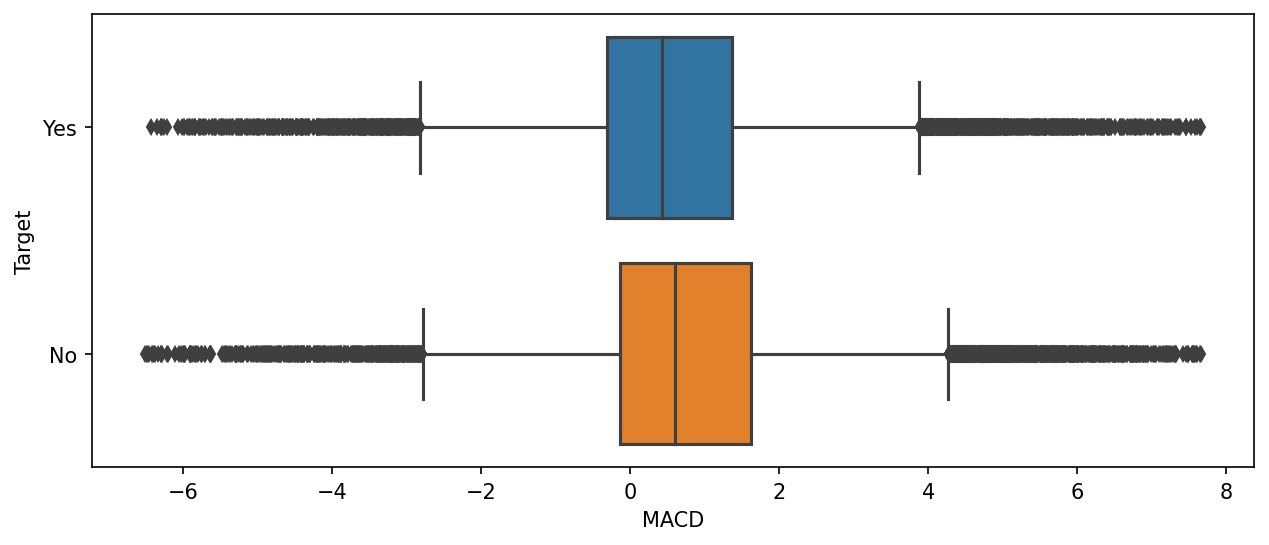

In [62]:
plt.figure(figsize=(10,4), dpi=150)
sns.boxplot(data=train, x='MACD', y='Target');

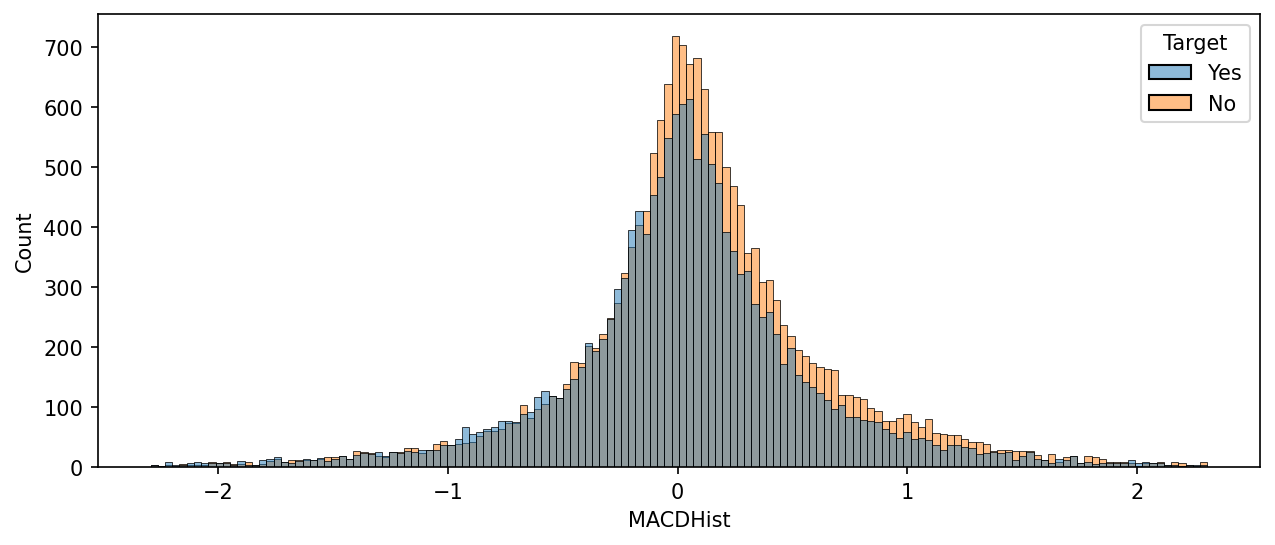

In [60]:
plt.figure(figsize=(10,4), dpi=150)
sns.histplot(data=train, x='MACDHist', hue='Target');

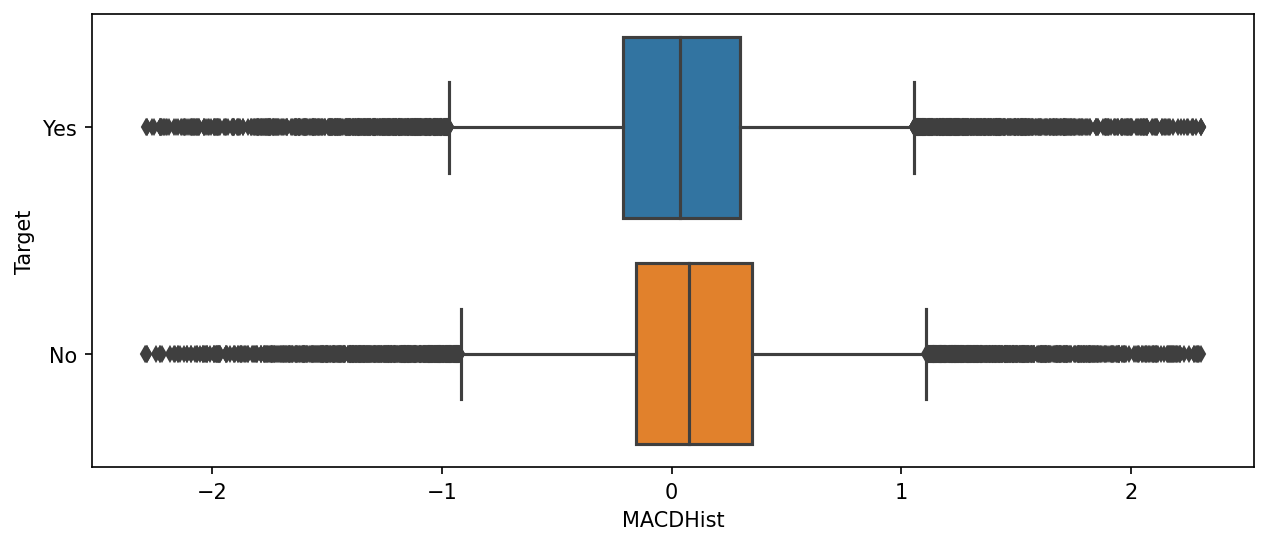

In [63]:
plt.figure(figsize=(10,4), dpi=150)
sns.boxplot(data=train, x='MACDHist', y='Target');

Because MACD and MACDHist work together to give an indication of the trend, let's look at the interaction term.

In [64]:
train['MACDInteraction'] = train['MACD']*train['MACDHist']

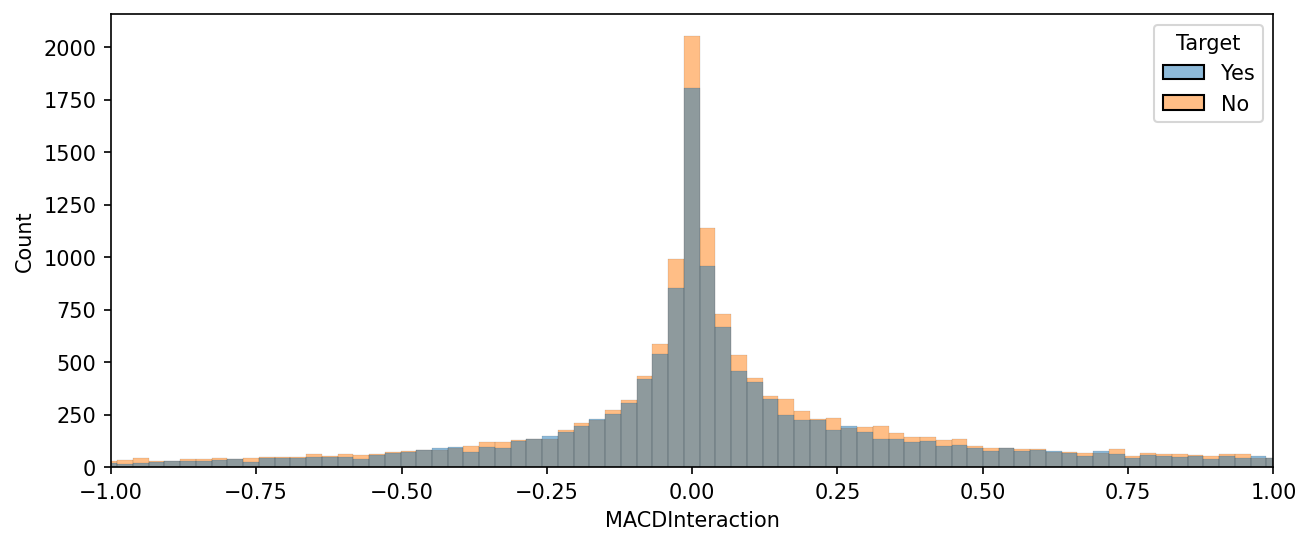

In [67]:
plt.figure(figsize=(10,4), dpi=150)
sns.histplot(data=train, x='MACDInteraction', hue='Target')

plt.xlim(-1, 1);

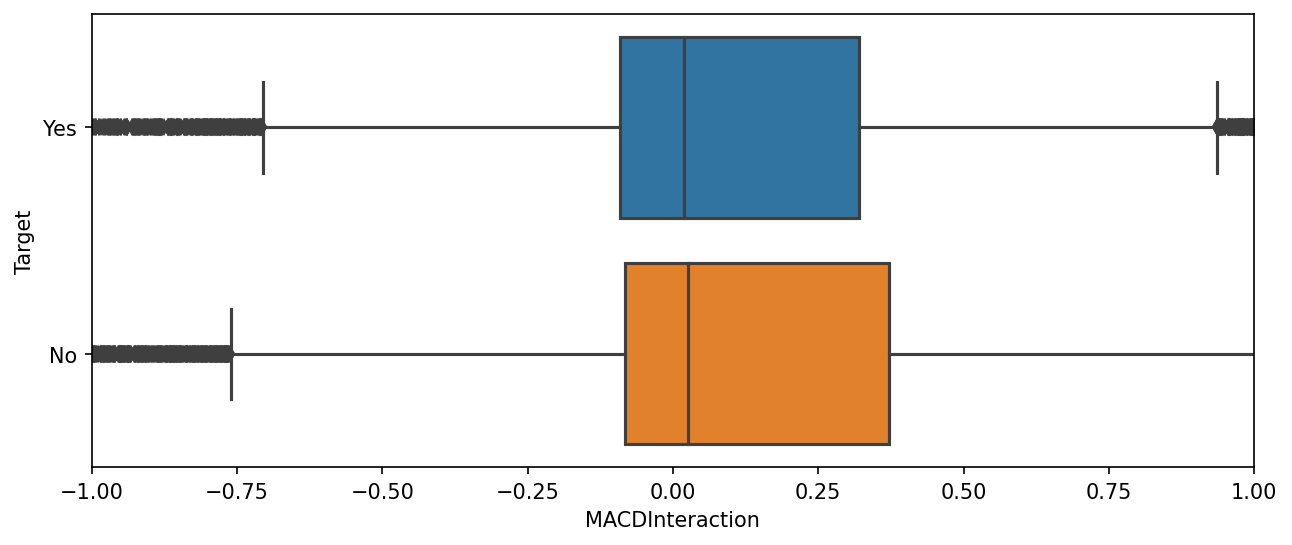

In [68]:
plt.figure(figsize=(10,4), dpi=150)
sns.boxplot(data=train, x='MACDInteraction', y='Target')

plt.xlim(-1, 1);

# Comments

Overall, most of the features tend to show minor trends but not major, as expected. As a result, I should not expect an exceptionally high classification (above 60%).

I will add a polynomial converter of degree=2 to the preprocessing step for the model to see if that will help model evaluation.